# Manual de usuario

Este cuaderno de Jupyter tiene como objetivo mostrar cómo utilizar un programa de Python diseñado para analizar los datos del proyecto DELTA con el fin de que pueda ser reutilizado con datos futuros. Primero, se explicarán los requisitos para su uso, seguido de la carga de un conjunto de datos de prueba para demostrar el uso de las partes más relevantes del código.

## Requisitos
Los requisitos son orientativos y han sido creados en base de los equipos dónde se ha probado el código:
 
### Requisitos del sistema
* Sistema operativo: Windows 10 o Windows 11.
* Memoria RAM: 8 gigabytes de RAM o mayor.
* CPU: Intel(R) Core(TM) i5 de 2.4 gigahercios de 11º generación o superior

### Requisitos de Python

#### Versión de Python
* Python 3.12.3 o superior

#### Librerías para el procesamiento y análsis de datos
* pandas
* scikit-learn
* matplotlib
* geopandas
* numpy
* scipy

#### Librerías para el análisis predictivo
* tensorflow
* keras

#### Opcional para hacer uso de jupyter notebooks
* notebook

#### Comando común para la instalación de paquetes

pip install pandas, numpy, scikit-learn, keras, tensorflow, scipy, matplotlib, geopandas, notebook

### Requisitos de datos

El programa está preparado para cargar datos que puedan estar en múltiples estructuras, en este caso se encontrarán ejemplos para datos fuente que estén en un csv con el siguiente formato:
- Columnas:
<div style="width: 100%; overflow-x: auto;">
    <code style="font-size: x-small; white-space: pre-wrap;">
TimeStamp,Vehicle,Latitude(deg),Longitude(deg),Pressure,Temperature,Conductivity,Oxygen,Salinity (PSU),Payload Data,Unnamed: 10,Unnamed: 11
    </code>
</div>

- Filas:
<div style="width: 100%; overflow-x: auto;">
    <code style="font-size: x-small; white-space: pre-wrap;">
11/24/2021 10:53 AM,PLOCAN (SO 4089),28.64769,-17.99594,0.21000000000000105,22.5985,5.29215,203.36926964128037,
36.8297,FD03000011360400C726080098950000, , 
    </code>
</div>



No obstante, si se modifican correctamente los parámetros de las diferentes clases, se pueden cargar CSVs en otros formatos.

### Conocimientos del usuario

El usuario debe tener conocimientos básicos de Python para preparar el entorno de ejecución y ejecutar el código, ya que no se ha desarrollado una interfaz de usuario. Para modificar el código, es necesario tener conocimientos medios de librerías fundamentales de Python como pandas y matplotlib.

Por otro lado, es importante destacar que todos los archivos de Python (.py) situados fuera de las carpetas, específicamente AnalysisCommonTools.py, Correlation.py, Glider2021Exploratory.py, Glider2022Exploratory.py, PredictiveSST.py, SeabedExploratory.py y Temporal.py, operan como scripts principales. Estos scripts simplemente llaman a las clases que se encuentran dentro de las carpetas para obtener los resultados necesarios para cada análisis. Por ejemplo, el archivo "Temporal.py" carga los datos correspondientes y guarda los resultados pertinentes para poder analizar la evolución temporal de los datos utilizando las clases dentro de las carpetas. Sin embargo, este archivo no es más que un script orquestador que no aporta una funcionalidad por si mismo. Estos ficheros se pueden utilizar como referencia a la hora de analizar nuevos datos, imitando sus pasos. Debido a esta estructura, el manual se enfoca en explicar cómo utilizar las clases que contienen las funcionalidades específicas y se encuentran divididas por carpetas.

## Funcionalidades de la aplicación

A continuación, se explican las partes fundamentales del código.


### Carga y preprocesamiento de los datos

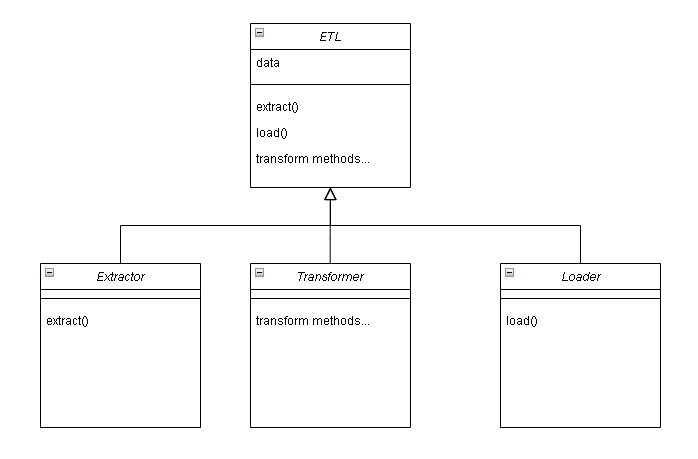

In [28]:
from IPython.display import display, Image
display(Image(filename="uml.png", width=700)) # Código para mostrar la imagen inferior


Se han creado una serie de clases relativas al preprocesado de tal forma que su mantenimiento y uso por personas poco familiarizadas con el código, sea sencillo. Estas clases tienen diferentes implementaciones:
* **Extractor**: 

Dependiendo de la fuente de datos, se utilizará una clase extractora u otra. Están implementadas para ficheros csv con la librería pandas y para ficheros geojson con la librería geopandas.
* **Transformer**: 

Se encarga de realizar las diferentes transformaciones, en este caso se ha creado una clase PandasTransformer con todas las funciones necesarias para limpiar y preprocesar datos a través de la librería pandas.
* **Loader**: 

Una vez los datos han sido extraídos y preprocesados, solo queda cargarlos, la carga consiste en la conversión a un objeto propio de este programa, de forma que, independientemente de que librería se utilice en estas fases, la salida del proceso ETL siempre será un objeto modelado que contiene la información cargada con tipos primitivos de Python. Por ejemplo, cuando se cargan los datos de la superficie del mar captados por un Wave Glider SV2, se utiliza la clase PandasWaveGliderV2OceanLoader que devuelve un objeto WaveGliderV2Ocean, cuyos atributos son las diferentes variables que se recogieron durante la misión, representadas con tipos primitivos de Python como "list" o "float".

La clase ETL es una clase genérica desde la que se llama las implementaciones mencionadas anteriormente a través de una "fluent interface", de forma que se podría realizar todo el proceso en una línea. Los parámetros extras que cada implementación pueda variar, se definen en la instanciación de la misma.


A continuación se muestra un ejemplo de uso con los datos de la superficie del mar del Wave Glider SV2:


Se importan las librerías necesarias: 

In [15]:
import operator

import pandas as pd
from etl.loaders.PandasWaveGliderV2OceanLoader import PandasWaveGliderV2OceanLoader
from etl.transformers.PandasTransformer import PandasTransformer
from etl.extractors.CSVPandasExtractor import CSVPandasExtractor
from etl.ETL import ETL

Se definen las herramientas ETL:

In [16]:
etl = ETL(CSVPandasExtractor(parse_dates = ["TimeStamp"], date_format="%m/%d/%Y %I:%M %p", relevant_cols_idx = [0, 2, 3, 4, 5, 6, 7, 8]), 
          PandasTransformer(),
          PandasWaveGliderV2OceanLoader())

En el siguiente paso, se extraen, preprocesan y cargan los datos, comenzando por renombrar las columnas a la nomenclatura general con un diccionario. Independientemente de los datos que se carguen, siempre se deben renombrar las variables para mantener una estructura en la aplicación: 
```
"TimeStamp"
"Temperature_C"
"Conductivity_S_m"
"Salinity_PSU"
"Oxygen_umol_L"
"Pressure_d"
"Latitude_deg"    
"Longitude_deg"
"Wind_speed_kt"
"Wind_gust_speed_kt"
"Wind_direction"
```

La misión de 2021 tuvo un desvío a partir del 9 de noviembre, se filtra con esa fecha hacia el pasado con la función filter_column del PandasTransformer, la cuál se llama desde el objeto ETL:



In [17]:
glider_21 = (etl
             .extract("./data/WG_211009_211124/MERGED_CTD_withOxygenCalc.csv")
             .rename_columns({"Temperature": "Temperature_C", "Conductivity": "Conductivity_S_m",
            "Salinity (PSU)": "Salinity_PSU", "Oxygen" : "Oxygen_umol_L",
            "Pressure": "Pressure_d", "Latitude(deg)": "Latitude_deg",
            "Longitude(deg)": "Longitude_deg"})
             .filter_column(col_name="TimeStamp", operator=operator.lt, value='2021-11-09 15:30:00') 
             .sort_values("TimeStamp")
             .load())

C:\Users\Usuario\PycharmProjects\LaPalmaEruptionAnalysis\etl\loaders\PandasWaveGliderV2OceanLoader.py:25: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  return list(column.dt.to_pydatetime())


El aviso se eliminará en futuras versiones, indica un cambio de tipo en la salida de la función to.pydatetime() de pandas, no obstante, ese cambio no afecta al programa actual. Cabe destacar que existen múltiples funciones en el proceso ETL que requieren datos de otro proceso ETL para su ejecución. Por ejemplo, la función:

```
def remove_values_not_in(self, col_with_values: str, etl_with_values_to_keep: Self) -> Self:
    self.data = self.transformer.remove_values_not_in(self.data, col_with_values, etl_with_values_to_keep.data)
    return self
```

Recibe como parámetro a otro objeto ETL (Self), y compara los valores que tienen ambos procesos en la columna "col_with_values", eliminando del objeto que ejecuta la función, los datos de la columna seleccionada que no encuentren en la misma columna del objeto ETL recibido como parámetro. Esto es útil para comparar datos semanales de dos fuentes diferentes y eliminar datos de días que no coincidan, por ejemplo si en una fuente existen datos los domingos y en la otra no existen datos esos días, se eliminarían de la primera los datos de los domingos para poder comparar sin problemas.

In [18]:
print("Primeros 5 valores de temperatura: ", glider_21.temperature_c[:5])

Primeros 5 valores de temperatura:  [24.001, 24.007, 23.9827, 23.9635, 23.9987]


Tal y como se aprecia en la salida de esta celda, los datos se han cargado correctamente.

### Graficar datos

A la hora de graficar los datos, se definen los parámetros en diferentes objetos propios para diferentes gráficos en la clase MatplotLibFigureCreator. Esta clase tiene sus funciones parametrizadas por lo que, a la hora de utilizarla, se puede comprobar previamente que clase de parámetros aceptan. Por ejemplo, si se tiene como objetivo graficar una evolución del tiempo, se puede utilizar la función para crear series de tiempo básicas, se define de la siguiente forma:

    def create_timeseries(self, plots_line_params: list[PlotStylishParams],
                          plot_scatter_params: list[PlotStylishParams], title: str,
                          timeseries_ticks: list):
                          
Para crear estas gráficas, se pueden enviar parámetros bien para que dibuje gráficas de líneas o bien para que dibuje gráficas de puntos (scatter), ambas del tipo de objeto "PlotStylishParams" que se construye de una forma u otra dependiendo de que se va a graficar y que librería se esté usando. Se pueden enviar tanto gráficas de líneas como de puntos al mismo tiempo para graficar diferentes variables de diferentes maneras. Los timeseries_ticks son los valores que se mostrarán en el eje "x", y se envía como una lista de cualquier tipo de valores. 

#### PlotStylishParams
Este objeto se compone a su vez, de múltiples objetos internos:
##### BasicPlotParams
Define los parámetros básicos de cualquier gráfica: valores del eje x, valores del eje y, y el título.
##### MarkerParams
Define valores de estilo, relacionados con el color, nombre de la variable, estilo de dibujo (depende de la librería, puede variar, y por último el tamaño de la marca aplicada a cada punto graficado. Este objeto es el que cambia fundamentalmente según si es un plot de puntos o de líneas.

Estilos posibles de líneas para MatPlotLib: https://matplotlib.org/stable/gallery/lines_bars_and_markers/linestyles.html

Estilos posibles de puntos para MatPlotLib: https://matplotlib.org/stable/gallery/lines_bars_and_markers/marker_reference.html
##### LimitedPlotArea
Define los límites de la gráfica.

Se realiza un ejemplo con esa función:

In [19]:
from model.params.LimitedPlotArea import LimitedPlotArea
from model.params.MarkerParams import MarkerParams
from model.params.BasicPlotParams import BasicPlotParams
from model.params.compound_params.PlotStylishParams import PlotStylishParams

plot_line_param = PlotStylishParams(
    BasicPlotParams(title="Gráfico de prueba de temperatura de líneas estilo -", x=glider_21.index, y=glider_21.temperature_c), 
    MarkerParams(color="red", label="Temperatura en grados", style="-", mark_size=1), 
    LimitedPlotArea(x_min=None, x_max=None, y_min=22, y_max=28) 
)

plot_scatter_param = PlotStylishParams(
    BasicPlotParams(title="Gráfico de prueba de conductividad de puntos estilo *", x=glider_21.index, y=glider_21.conductivity_s_m), 
    MarkerParams(color="green", label="Conductividad en S/m", style="*", mark_size=5), 
    LimitedPlotArea(x_min=None, x_max=None, y_min=5, y_max=6) 
)

A la hora de utilizar la clase, es importante crearla correctamente antes de utilizarla, pues al instanciarla se define el tamaño de la gráfica, y como se construye en base a filas y columnas: 

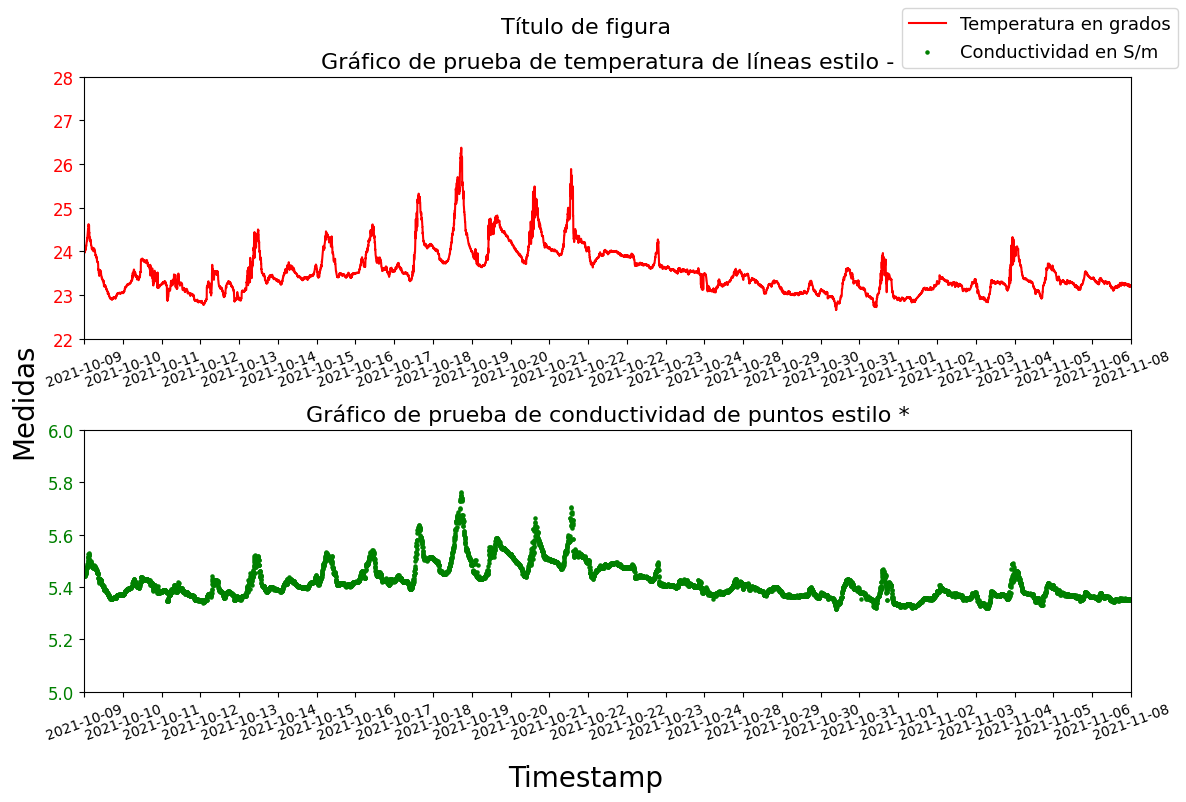

In [20]:
from visualizer.MatplotlibFigureVisualizer import MatplotlibFigureVisualizer
from graphers.MatplotlibFigureCreator import MatplotlibFigureCreator

grapher = (MatplotlibFigureCreator(n_rows=2, n_cols=1, fig_size=(12,8))
           .create_timeseries(
    plots_line_params=[plot_line_param], 
    plot_scatter_params=[plot_scatter_param], 
    title="Título de figura",
    timeseries_ticks=glider_21.timestamp)
)
# MatplotlibFigureStorer().store("./test.png") # para guardarlo (en jupyter notebooks se muestra una visualización igualemente antes de guardarse)
MatplotlibFigureVisualizer().visualize()


Una vez creada la gráfica, se puede elegir entre guardarla como un archivo o mostrarla. Para ello, se utiliza la clase "MatplotlibFigureVisualizer" si se desea graficarla, o la clase "MatplotlibFigureStorer" si se quiere guardar como un fichero.


### Analizar datos, y graficar sus spikes

En este apartado se introducirá un conjunto de clases dedicadas a analizar datos mediante técnicas estadísticas, para asegurar la independencia de estas clases con las librerías que utilizan, sus salidas son siempre tipos primitivos de Python u objetos propios del programa como el objeto Table, que simula los datos de una tabla. A continuación, se muestra una simple descripción de los datos ya cargados en el apartado anterior. Para que se pueda mostrar de forma legible en el jupyter notebook, se utilizará la librería pandas, transformando el objeto propio Table en un objeto pd.Dataframe:

In [21]:
from analyzers.PandasWaveGliderV2OceanAnalyzer import PandasWaveGliderV2OceanAnalyzer

table_description = PandasWaveGliderV2OceanAnalyzer().describe(glider_21)
pd.DataFrame(index=table_description.indexes, data=dict(map(lambda i, j: (i, j),
                                                               map(lambda col: col.label, table_description.columns),
                                                               map(lambda col: col.values, table_description.columns))))

,TimeStamp,Temperature_C,Conductivity_S_m,Salinity_PSU,Pressure_d,Oxygen_umol_L
count,8206,8206.000000,8206.000000,8206.000000,8206.000000,8206.000000
mean,None,23.533672,5.416338,37.006631,0.233708,203.344256
min,2021-10-09 13:14:00,22.661100,5.316300,36.631200,0.150000,160.649923
25%,2021-10-16 05:36:15,23.198050,5.368853,36.904550,0.220000,202.700225
50%,2021-10-22 17:22:30,23.411750,5.399385,37.025600,0.230000,205.900346
75%,2021-11-01 11:21:45,23.779200,5.445970,37.066100,0.250000,207.450215
max,2021-11-08 15:13:00,26.376400,5.763330,37.274400,0.330000,213.838850
std,NaN,0.501641,0.065079,0.121870,0.022029,7.554634


Existen múltiples funciones para analyzar datos, y todas aquellas que devuelvan un objeto del tipo "Table" se pueden guardar fácilmente utilizando la clase CsvPandasStorer:

In [22]:
from storer.CsvPandasStorer import CsvPandasStorer

CsvPandasStorer().store(table_description, "./descripcion_de_datos_de_prueba.csv", "%d/%m/%Y %H:%M", True)

A continuación, se muestra un ejemplo sobre cómo analizar datos relativos a spikes, por un lado, se deben cargar los datos y localizar los spikes con la clase Analyzer correspondiente. Esta clase debe ser instanciada con los datos que se vayan a utilizar conjuntamente para crear el umbral de detección de spikes por variable:

In [23]:
spikes = PandasWaveGliderV2OceanAnalyzer(glider_21).analyze_outliers_oxygen(glider_21)
spikes_table = spikes.to_table()
pd.DataFrame(index=spikes_table.indexes, data=dict(map(lambda i, j: (i, j),
                                                               map(lambda col: col.label, spikes_table.columns),
                                                               map(lambda col: col.values, spikes_table.columns))))

C:\Users\Usuario\PycharmProjects\LaPalmaEruptionAnalysis\analyzers\PandasWaveGliderV2OceanAnalyzer.py:54: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  return Spikes([variable_enum] * len(outliers.index), spike_threshold, list(outliers["TimeStamp"].dt.to_pydatetime()),


,Variable,Threshold,TimeStamp,Values
5110,Oxygen_umol_L,7.124985,2021-10-28 20:24:00,200.236352
5113,Oxygen_umol_L,7.124985,2021-10-28 20:35:00,199.099017
6009,Oxygen_umol_L,7.124985,2021-10-31 23:15:00,160.649923
6019,Oxygen_umol_L,7.124985,2021-11-01 00:05:00,182.559384
6037,Oxygen_umol_L,7.124985,2021-11-01 01:35:00,192.983472
6126,Oxygen_umol_L,7.124985,2021-11-01 09:04:00,175.329143


El siguiente paso consiste en graficar estos datos, para los cuáles existe una variación del objeto "PlotStylishParams" llamada "PlotStylishSpikesParams":

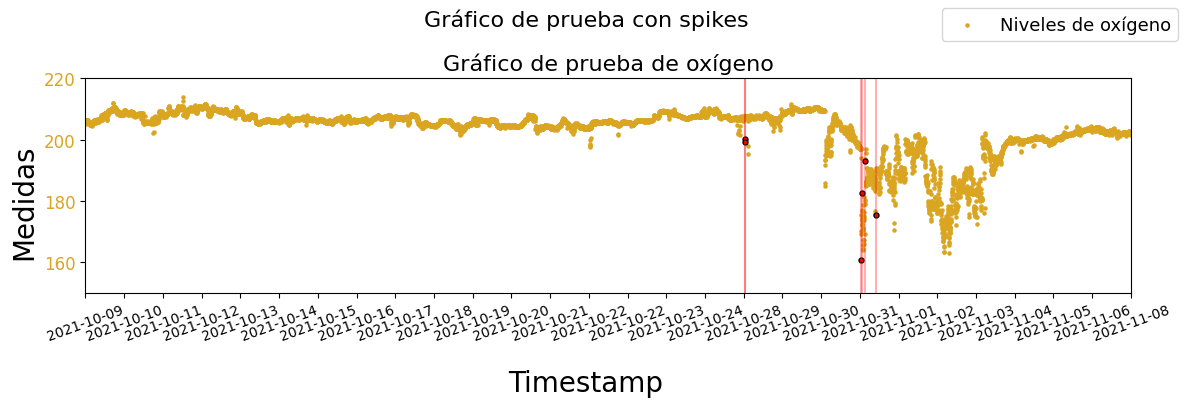

In [24]:
from model.params.compound_params.PlotStylishSpikesParams import PlotStylishSpikesParams
from model.params.SpikesParams import SpikesParams

plot_scatter_param = PlotStylishSpikesParams(
    BasicPlotParams(title="Gráfico de prueba de oxígeno", x=glider_21.index, y=glider_21.oxygen), 
    MarkerParams(color="goldenrod", label="Niveles de oxígeno", style="*", mark_size=5), 
    LimitedPlotArea(x_min=None, x_max=None, y_min=150, y_max=220),
    SpikesParams(spikes_indexes=spikes.indexes,
                 spikes_values=spikes.values,
                 spike_colour="red")
)
MatplotlibFigureCreator(n_rows=1, n_cols=1, fig_size=(12,4)).create_timeseries_with_outliers([], [plot_scatter_param], "Gráfico de prueba con spikes", glider_21.timestamp)
MatplotlibFigureVisualizer().visualize()


El siguiente paso consiste en persistir los outliers encontrados con la clase CsvPandasStorer(), y así poder se puedan interpolar en la carga de análisis futuros con la función "interpolate_outliers" del transformador de Pandas utilizado desde la clase ETL:

In [25]:
from etl.loaders.PandasSpikesLoader import PandasSpikesLoader
from model.Spikes import Spikes

CsvPandasStorer().store(spikes.to_table(), "./outliers_prueba.csv", "%d/%m/%Y %H:%M", True)

def get_spikes(csv_filename: str) -> Spikes:
    return (ETL(CSVPandasExtractor(["TimeStamp"],  "%d/%m/%Y %H:%M", [0, 1, 2, 3, 4], ",", [0]),
                   PandasTransformer(),
                   PandasSpikesLoader())
            .extract(csv_filename)
            .load())

# Se cargan de nuevo en futuros análisis en ejecuciones de código diferentes.
spikes = get_spikes("./outliers_prueba.csv")

# Se define el objeto que llevará a cabo el proceso ETL.
etl = ETL(CSVPandasExtractor(parse_dates = ["TimeStamp"], date_format="%m/%d/%Y %I:%M %p", relevant_cols_idx = [0, 2, 3, 4, 5, 6, 7, 8]), 
          PandasTransformer(),
          PandasWaveGliderV2OceanLoader())

# Se interpolan los spikes en la carga de datos:
glider_21_cleaned = (etl
             .extract("./data/WG_211009_211124/MERGED_CTD_withOxygenCalc.csv")
             .rename_columns({"Temperature": "Temperature_C", "Conductivity": "Conductivity_S_m",
            "Salinity (PSU)": "Salinity_PSU", "Oxygen" : "Oxygen_umol_L",
            "Pressure": "Pressure_d", "Latitude(deg)": "Latitude_deg",
            "Longitude(deg)": "Longitude_deg"})
             .filter_column(col_name="TimeStamp", operator=operator.lt, value='2021-11-09 15:30:00') 
             .interpolate_outliers(outliers=spikes, timestamps_label="TimeStamp") # Este es el paso para interpolar outliers
             .sort_values("TimeStamp")
             .load())
glider_21_cleaned.temperature_c[:5]

C:\Users\Usuario\PycharmProjects\LaPalmaEruptionAnalysis\etl\loaders\PandasSpikesLoader.py:11: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  list(df["TimeStamp"].dt.to_pydatetime()),
C:\Users\Usuario\PycharmProjects\LaPalmaEruptionAnalysis\etl\loaders\PandasWaveGliderV2OceanLoader.py:25: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  return list(column.dt.to_pydatetime())


[24.001, 24.007, 23.9827, 23.9635, 23.9987]

### Análisis predictivo

Para utilizar estas herramientas se recomienda tener conocimientos básicos de inteligencia articial en Python y para poder modificar parámetros y agregar modelos al código, ajustando el programa a los objetivos y datos que sean necesarios.

En este manual se realizará un ejemplo con el modelo ElasticNet de la librería Sklearn, y un preprocesando los datos de entrada con el StandardScaler de la misma librería.

La clase ModelManager trata de ocultar la lógica de como se gestionan estos modelos, de forma que se le inyectarán las clases nombradas en el constructor y se trabajarán con ellas desde fuera. En esta prueba se tratará de realizar una predicción muy sencilla calculando la conductividad a partir de la temperatura. La primera mitad de la misión de 2021 se utilizará de entrenamiento y la segunda mitad como test:

In [26]:
from machine_learning.ModelManager import ModelManager
from machine_learning.models.SklearnElasticNetModel import SklearnElasticNetModel
from machine_learning.model_preprocessors.SklearnStandardScaler import SklearnStandardScaler
half_index = len(glider_21_cleaned.temperature_c)//2
train_x, train_y = [glider_21_cleaned.temperature_c[:half_index]], [glider_21_cleaned.conductivity_s_m[:half_index]]
test_x, test_y = [glider_21_cleaned.temperature_c[half_index:]], [glider_21_cleaned.conductivity_s_m[half_index:]]

models = {"Elastic Net": SklearnElasticNetModel()}
scaler = SklearnStandardScaler()
model_manager = ModelManager(scaler, models)
model_manager.train(train_x, train_y)
predict_result = model_manager.predict(test_x, test_y)
print("Primeros 5 valores reales:",predict_result.get("Elastic Net").y_true[0][:5])
print("Primeros 5 valores predichos:",predict_result.get("Elastic Net").y_pred[0][:5])
print("Error obtenido de la predicción con el método MSE:",predict_result.get("Elastic Net").error)

C:\Users\Usuario\interpreters\python\tfg_2\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


Primeros 5 valores reales: [5.4894  5.48954 5.49133 5.49054 5.49158]
Primeros 5 valores predichos: [5.4451  5.44534 5.44215 5.43996 5.44407]
Error obtenido de la predicción con el método MSE: 0.012371514772337309


Tal y como se puede observar, debido a la fuerte correlación de estas variables, esta predicción ha sido muy sencilla hacer y ha dado buenos resultados.